In [1]:
import sys
import os

REPO_PATH = r"C:\Users\tskor\Documents\GitHub\inovation_project\2_gc-pipeline" # Specify a local path to the repository (or use installed package instead)
os.environ["WANDB_DIR"] = r"C:\Users\tskor\Documents\GitHub\inovation_project\2_gc-pipeline"
sys.path.append(REPO_PATH)

from models.mlp import Mlp, mlp_data_preparation
from models.lstm import Lstm, LstmWithAttention, lstm_data_preparation
from models.cnn import Cnn2D, Cnn2DLstm, cnn_data_preparation

import numpy as np
from data.test_train_split import test_train_split
import matplotlib.pyplot as plt
import tensorflow as tf
import json
from models.utils import save_weight_statistics, load_weight_statistics, pen_low_loss, pen_low_lenient_high_loss
import wandb
from scipy import stats


#### Data preparation

In [2]:
config_data = {
    "months": 3,
    "num_bands": 9,
    "num_buckets": 60,
    "batch_size": 32,
}

dataset_path = rf"C:\Users\tskor\Documents\GitHub\inovation_project\2_gc-pipeline\test_data\dataset_nan_map_True_norm_True_{config_data['num_buckets']}_buckets_{config_data['num_bands']}_bands_60_dataset_fips.npy"   
labels_path = rf"C:\Users\tskor\Documents\GitHub\inovation_project\2_gc-pipeline\test_data\dataset_nan_map_True_norm_True_{config_data['num_buckets']}_buckets_{config_data['num_bands']}_bands_60_labels.npy"



#### MLP

In [3]:
mlp_dataset, labels = mlp_data_preparation(dataset_path, labels_path)
mlp_train_dataset, mlp_val_dataset, mlp_test_dataset = test_train_split(mlp_dataset,
                                                            labels,
                                                            **config_data)

In [4]:
mlp_dataset.shape


(9578, 1623)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: t-skorkowski. Use `wandb login --relogin` to force relogin


Epoch 1/300
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 10899.6289 - mae: 82.4648 - mse: 10255.2852 - val_loss: 4629517312.0000 - val_mae: 1874.8369 - val_mse: 5143907328.0000
Epoch 2/300
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1377.2915 - mae: 25.0334 - mse: 1018.0611 - val_loss: 1758892288.0000 - val_mae: 1160.8134 - val_mse: 1954324352.0000
Epoch 3/300
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1079.5134 - mae: 21.4935 - mse: 774.4610 - val_loss: 1110352000.0000 - val_mae: 926.3251 - val_mse: 1233724032.0000
Epoch 4/300
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 978.2007 - mae: 20.1751 - mse: 708.4257 - val_loss: 897401536.0000 - val_mae: 834.3008 - val_mse: 997112448.0000
Epoch 5/300
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 911.3333 - mae: 19.1932 - mse: 659.3912 - val_loss: 765220480.0000 - val_mae: 771.8424 - val_mse: 850244736.0000
Epoch 6/300
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 860.2037 - mae: 18.4288 - mse: 622.2054 - val_loss: 74

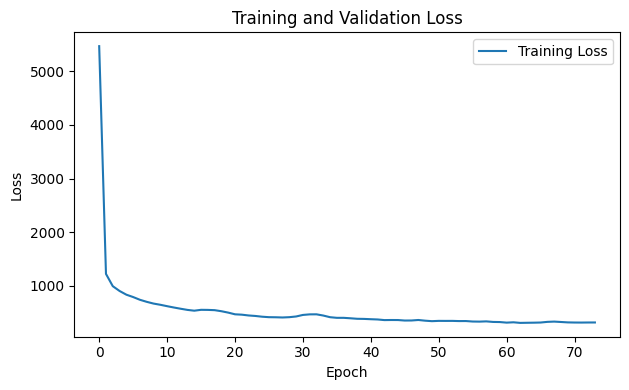

epoch/epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/mae,█▃▂▂▂▂▂▂▂▂▂▁▁▁▁▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/mse,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_loss,█▄▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_mae,█▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_mse,█▇▇▅▆▅▄▄▄▃▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/epoch,73
epoch/learning_rate,0.001
epoch/loss,316.14999


In [5]:

mlp_config = {
    "input_shape": (config_data["months"]
                  * config_data["num_buckets"]
                  * config_data["num_bands"],),
    "no_units": [100,] * 5,
}
mlp_model = Mlp(**mlp_config)
mlp_model.compile(learning_rate=0.00001, loss=pen_low_loss, metrics=["mae", "mse"])
mlp_model.fit(mlp_train_dataset,
         mlp_val_dataset,
         epochs=300)

# After training
original_weights = [w.numpy() for w in mlp_model.weights]

mlp_model.trainable = False
wandb.finish()  

In [6]:
mlp_eval = mlp_model.evaluate(mlp_test_dataset)
print(mlp_eval)


 1/59 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 908.2755 - mae: 23.1053 - mse: 779.8162

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1036.1678 - mae: 22.5587 - mse: 857.6132
[1065.7677001953125, 22.432035446166992, 840.5669555664062]


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


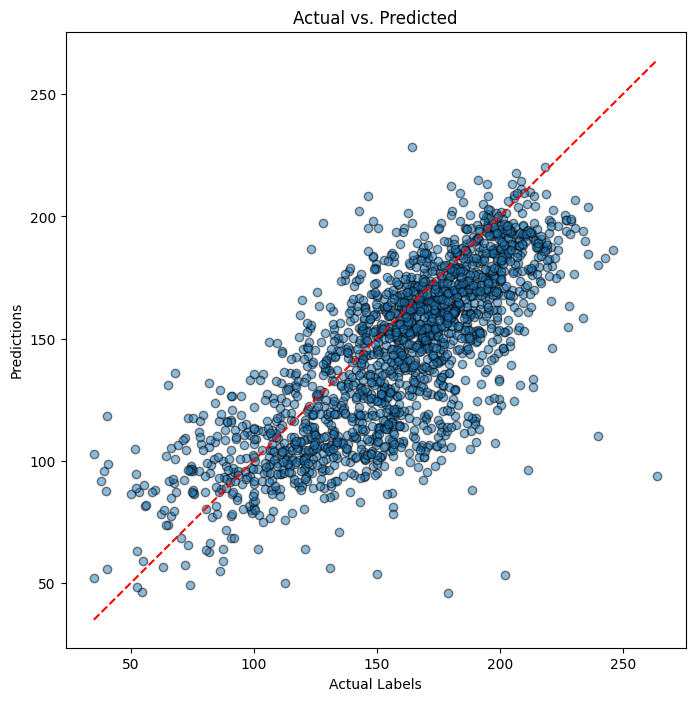

In [7]:
mlp_predictions = mlp_model.predict(mlp_test_dataset)
actual_labels = np.concatenate([response.numpy() for _, response in mlp_test_dataset], axis=0)

# Plot actual vs. predicted
plt.figure(figsize=(8, 8))
plt.scatter(actual_labels, mlp_predictions, alpha=0.5, edgecolors='k')
plt.xlabel('Actual Labels')
plt.ylabel('Predictions')
plt.title('Actual vs. Predicted')
plt.plot([min(actual_labels), max(actual_labels)], [min(actual_labels), max(actual_labels)], 'r--')  # Line y=x for reference
plt.show()

In [8]:
test_responses = []
for _, response in mlp_test_dataset:
    test_responses.append(response.numpy())

test_responses = np.concatenate(test_responses, axis=0)

mean_train_response = tf.reduce_mean([y for _, y in mlp_train_dataset]).numpy()

baseline_loss = sum(((mean_train_response - test_responses) ** 2)/len(test_responses))
print(sum(baseline_loss))


1402.0701904296875


#### LSTM

In [9]:
lstm_dataset, labels = lstm_data_preparation(dataset_path, labels_path)
lstm_train_dataset, lstm_val_dataset, lstm_test_dataset = test_train_split(lstm_dataset,
                                                                            labels,
                                                                            **config_data)

Epoch 1/300
191/191 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - loss: 18137.4902 - mae: 127.3387 - val_loss: 6238.2017 - val_mae: 71.0713
Epoch 2/300
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 4806.8428 - mae: 61.3118 - val_loss: 2176.5742 - val_mae: 39.5647
Epoch 3/300
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 1871.2874 - mae: 36.6498 - val_loss: 1533.6412 - val_mae: 31.8590
Epoch 4/300
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 1436.6919 - mae: 30.9547 - val_loss: 1483.1591 - val_mae: 30.8044
Epoch 5/300
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 1399.6802 - mae: 30.0123 - val_loss: 1482.0133 - val_mae: 30.6774
Epoch 6/300
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 1397.3560 - mae: 29.8763 - val_loss: 1482.1488 - val_mae: 30.6602
Epoch 7/300
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 1397.1183 - mae: 29.8561 - val_loss: 1482.2784 - val_mae: 30.6595
Epoch 8/300
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 1401.7758 - mae: 29.8796 - val_loss: 14

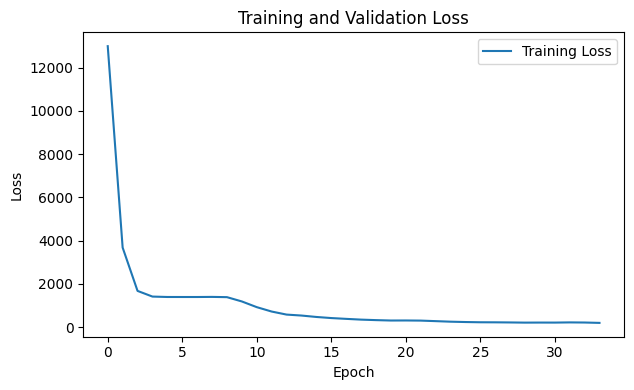

epoch/epoch,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/mae,█▄▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_loss,█▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_mae,█▄▃▃▃▃▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/epoch,33
epoch/learning_rate,0.001
epoch/loss,199.78796
epoch/mae,9.22424
epoch/val_loss,751.55853


In [10]:
train_lstm = True
model_path = r"C:\Users\tskor\Documents\GitHub\inovation_project\2_gc-pipeline\models\saved\\"
model_name = "LSTM-angry-mayo-20241101-102955.keras"
if train_lstm:
    wandb.init(project="blue-marble")
    config_lstm = {
        "input_shape": (config_data["months"], config_data["num_buckets"] * config_data["num_bands"]),
        "no_lstm_units": [200,] * 7,
        "attention_units": 200,
    }
    lstm_model = LstmWithAttention(**config_lstm)
    lstm_model.compile(learning_rate=0.00013)
    lstm_model.fit(lstm_train_dataset,
            lstm_val_dataset,
            epochs=300)

    lstm_model.trainable = False
    wandb.finish()
else:
    lstm_model = tf.keras.models.load_model(model_path + model_name)
    lstm_model.compile()

In [28]:
lstm_eval = lstm_model.evaluate(lstm_test_dataset)
print(lstm_eval)

print(f"LSTM detalis: {lstm_model.summary()}")


 1/59 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 392.3214 - mae: 15.7233

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 540.9031 - mae: 17.8585
[578.7725830078125, 18.502676010131836]


Model: "lstm_with_attention"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (32, 3, 200)           │       593,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (32, 3, 200)           │       320,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (32, 3, 200)           │       320,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (32, 3, 200)           │       320,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (32, 3, 200)           │       320,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (32, 3, 200)           │       320,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (32, 3, 200)           │       320,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer                 │ ?                      │        80,601 │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (32, 1)                │           401 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,798,208 (29.75 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,599,402 (9.92 MB)

 Optimizer params: 5,198,806 (19.83 MB)

LSTM detalis: None


#### CNN

In [12]:
config_data = {
    "months": 3,
    "num_bands": 9,
    "num_buckets": 60,
    "batch_size": 32,
}

dataset_path = rf"C:\Users\tskor\Documents\GitHub\inovation_project\2_gc-pipeline\test_data\dataset_nan_map_True_norm_True_{config_data['num_buckets']}_buckets_{config_data['num_bands']}_bands_60_dataset.npy"   
labels_path = rf"C:\Users\tskor\Documents\GitHub\inovation_project\2_gc-pipeline\test_data\dataset_nan_map_True_norm_True_{config_data['num_buckets']}_buckets_{config_data['num_bands']}_bands_60_labels.npy"

In [13]:

cnn_dataset, labels = cnn_data_preparation(dataset_path, labels_path, **config_data)
cnn_train_dataset, cnn_val_dataset, cnn_test_dataset = test_train_split(cnn_dataset,
                                                                            labels,
                                                                            **config_data)

In [14]:
print(config_data["months"], config_data["num_buckets"], config_data["num_bands"], sep=", ")


3, 60, 9


Epoch 1/300
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - loss: 6746.2598 - mae: 59.4746 - val_loss: 1853.0472 - val_mae: 34.1306
Epoch 2/300
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - loss: 1510.6595 - mae: 28.6578 - val_loss: 1588.6497 - val_mae: 31.3251
Epoch 3/300
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - loss: 1295.1233 - mae: 26.2630 - val_loss: 1308.1451 - val_mae: 27.3620
Epoch 4/300
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - loss: 1176.2167 - mae: 24.8585 - val_loss: 1133.6371 - val_mae: 24.5912
Epoch 5/300
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - loss: 1091.2986 - mae: 23.7916 - val_loss: 1061.7142 - val_mae: 23.3376
Epoch 6/300
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - loss: 1036.2802 - mae: 23.1388 - val_loss: 1057.2203 - val_mae: 23.7361
Epoch 7/300
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 60ms/step - loss: 998.8826 - mae: 22.7497 - val_loss: 1019.2712 - val_mae: 23.0998
Epoch 8/300
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - loss: 964.8005 - mae: 22.3594 - val_loss:

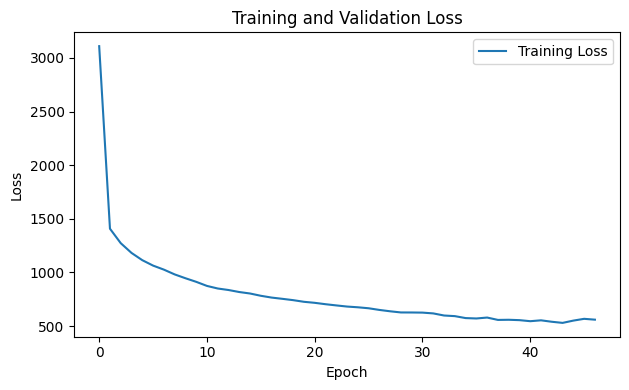

epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/mae,█▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_loss,█▆▅▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_mae,█▇▅▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/epoch,46
epoch/learning_rate,0.001
epoch/loss,559.40546
epoch/mae,16.05984
epoch/val_loss,780.84656


In [15]:
wandb.init(project="blue-marble")
config_cnn = {
    "input_shape": (config_data["months"], config_data["num_buckets"], config_data["num_bands"]),
    "conv_filters": [348, 128],
    "dense_units": [100] * 3,
    "conv_kernel_size": (3, 3),
    "pool_size": (2, 2),
    "dropout_rate": 0.35,
    "l1_reg": 0.03,
    "l2_reg": 0.03,

}
cnn_model = Cnn2D(**config_cnn)
cnn_model.compile(learning_rate=0.0005)
cnn_model.fit(cnn_train_dataset,
        cnn_val_dataset,
        epochs=300)

cnn_model.trainable = False
wandb.finish()

In [16]:
cnn_eval = cnn_model.evaluate(cnn_test_dataset)
print(cnn_eval)


 1/59 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 529.8721 - mae: 16.9314

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 704.7237 - mae: 18.6686
[708.8502807617188, 18.67768669128418]


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


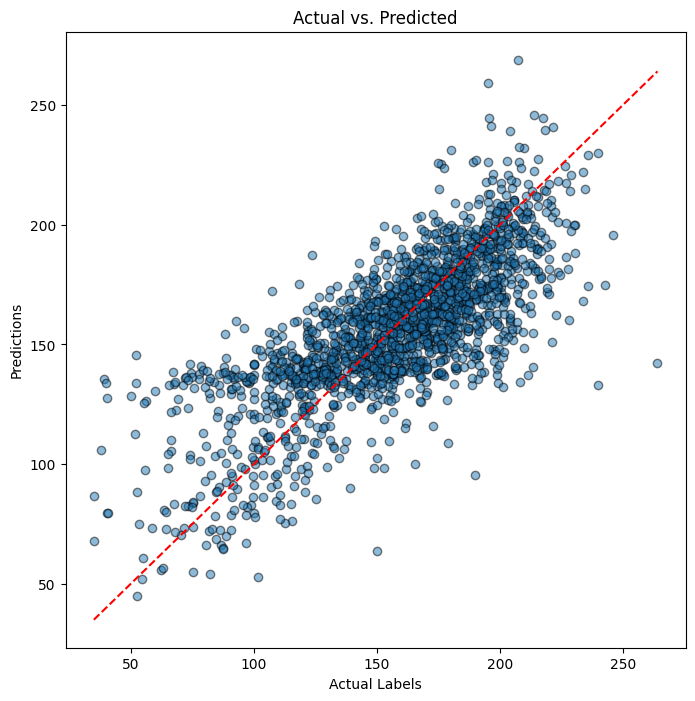


Correlations using scipy.stats.pearsonr:
CNN correlation: 0.759 (p-value: 0.000e+00)


Model: "Cnn2D-tranquil-stew-20241104-002623"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (32, 348, 58, 7)       │         9,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 128, 27, 5)       │       200,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 174, 29, 7)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 64, 13, 5)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 4160)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (32, 100)              │       416,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (32, 100)              │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (32, 100)              │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (32, 100)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (32, 1)                │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,940,165 (7.40 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 646,721 (2.47 MB)

 Optimizer params: 1,293,444 (4.93 MB)

CNN detalis: None


In [17]:
cnn_predictions = cnn_model.predict(cnn_test_dataset)
actual_labels = np.concatenate([response.numpy() for _, response in cnn_test_dataset], axis=0)

# Plot actual vs. predicted
plt.figure(figsize=(8, 8))
plt.scatter(actual_labels, cnn_predictions, alpha=0.5, edgecolors='k')
plt.xlabel('Actual Labels')
plt.ylabel('Predictions')
plt.title('Actual vs. Predicted')
plt.plot([min(actual_labels), max(actual_labels)], [min(actual_labels), max(actual_labels)], 'r--')  # Line y=x for reference
plt.show()

cnn_corr, cnn_p = stats.pearsonr(actual_labels.flatten(), cnn_predictions.flatten())
print("\nCorrelations using scipy.stats.pearsonr:")
print(f"CNN correlation: {cnn_corr:.3f} (p-value: {cnn_p:.3e})")

print(f"CNN detalis: {cnn_model.summary()}")


#### Comparison

 6/59 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


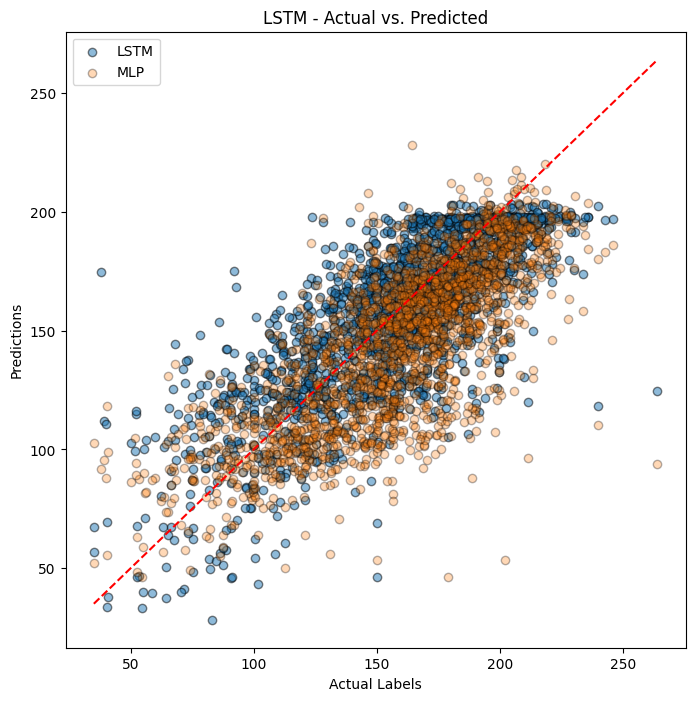


Correlations using scipy.stats.pearsonr:
MLP correlation: 0.750 (p-value: 0.000e+00)
LSTM correlation: 0.777 (p-value: 0.000e+00)
CNN correlation: 0.759 (p-value: 0.000e+00)
Mean of actual labels: 157.40


In [30]:
lstm_predictions = lstm_model.predict(lstm_test_dataset)
actual_labels = np.concatenate([response.numpy() for _, response in lstm_test_dataset], axis=0)

# Plot actual vs. predicted
plt.figure(figsize=(8, 8))
plt.scatter(actual_labels, lstm_predictions, alpha=0.5, edgecolors='k', label="LSTM")
plt.scatter(actual_labels, mlp_predictions, alpha=0.3, edgecolors='k', label="MLP")
plt.xlabel('Actual Labels')
plt.ylabel('Predictions')
plt.title('LSTM - Actual vs. Predicted')
plt.plot([min(actual_labels), max(actual_labels)], [min(actual_labels), max(actual_labels)], 'r--')  # Line y=x for reference
plt.legend()
plt.show()

mlp_corr, mlp_p = stats.pearsonr(actual_labels.flatten(), mlp_predictions.flatten())
lstm_corr, lstm_p = stats.pearsonr(actual_labels.flatten(), lstm_predictions.flatten())
cnn_corr, cnn_p = stats.pearsonr(actual_labels.flatten(), cnn_predictions.flatten())
print("\nCorrelations using scipy.stats.pearsonr:")
print(f"MLP correlation: {mlp_corr:.3f} (p-value: {mlp_p:.3e})")
print(f"LSTM correlation: {lstm_corr:.3f} (p-value: {lstm_p:.3e})")
print(f"CNN correlation: {cnn_corr:.3f} (p-value: {cnn_p:.3e})")

print(f"Mean of actual labels: {np.mean(actual_labels):.2f}")



In [32]:
# loss below treshold
low_yield_treshold = 100
low_yeild_mask = actual_labels < low_yield_treshold

low_yield_labels = actual_labels[low_yeild_mask]
mlp_low_predictions = mlp_predictions[low_yeild_mask]
lstm_low_predictions = lstm_predictions[low_yeild_mask]
cnn_low_predictions = cnn_predictions[low_yeild_mask]

mlp_mse_low = sum((mlp_predictions[low_yeild_mask] - actual_labels[low_yeild_mask])**2) / len(low_yeild_mask)
lstm_mse_low = sum((lstm_predictions[low_yeild_mask] - actual_labels[low_yeild_mask])**2) / len(low_yeild_mask)
cnn_mse_low = sum((cnn_predictions[low_yeild_mask] - actual_labels[low_yeild_mask])**2) / len(low_yeild_mask)

print(f"MLP RMSE low yield: {np.sqrt(mlp_mse_low):.2f}")
print(f"LSTM RMSE low yield: {np.sqrt(lstm_mse_low):.2f}")
print(f"CNN RMSE low yield: {np.sqrt(cnn_mse_low):.2f}")
print(f"Low yield %: {float(np.sum(low_yeild_mask)/len(low_yeild_mask)):.2%}")


MLP RMSE low yield: 7.45
LSTM RMSE low yield: 10.40
CNN RMSE low yield: 11.96
Low yield %: 8.37%


In [34]:
len(low_yeild_mask) * 0.0837

158.0256

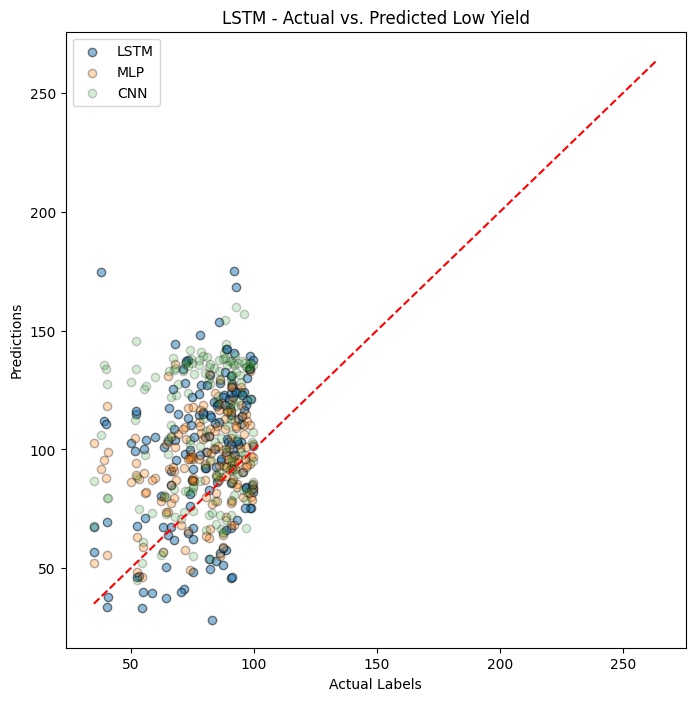

In [35]:
# Plot low yield actual vs. predicted
plt.figure(figsize=(8, 8))
plt.scatter(low_yield_labels, lstm_low_predictions, alpha=0.5, edgecolors='k', label="LSTM")
plt.scatter(low_yield_labels, mlp_low_predictions, alpha=0.3, edgecolors='k', label="MLP")
plt.scatter(low_yield_labels, cnn_low_predictions, alpha=0.2, edgecolors='k', label="CNN")
plt.xlabel('Actual Labels')
plt.ylabel('Predictions')
plt.title('LSTM - Actual vs. Predicted Low Yield')
plt.plot([min(actual_labels), max(actual_labels)], [min(actual_labels), max(actual_labels)], 'r--')  # Line y=x for reference
plt.legend()
plt.show()

#### Residuals

C:\Users\tskor\AppData\Local\Temp\ipykernel_22392\3428180465.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(residuals_for_plot, labels=labels)


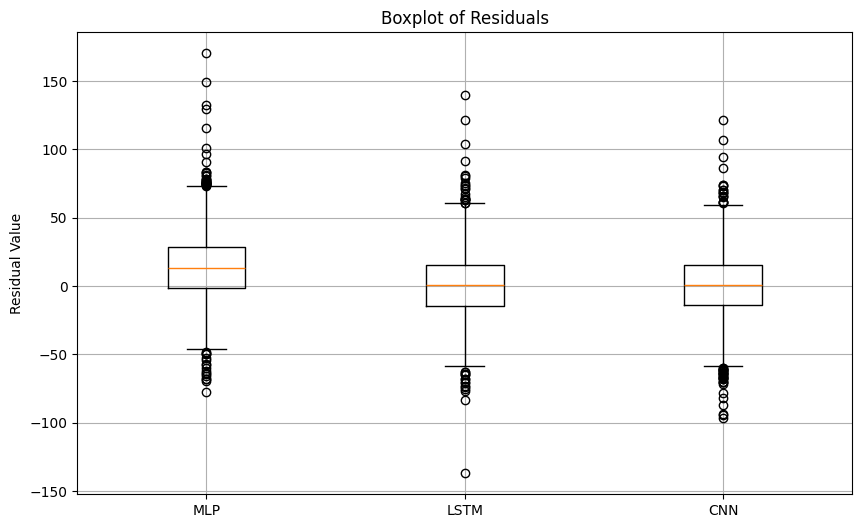

In [21]:
residuals = [actual_labels - x for x in [mlp_predictions, lstm_predictions, cnn_predictions]]
residuals_for_plot = [residual.flatten() for residual in residuals]

labels = ["MLP", "LSTM", "CNN"]

plt.figure(figsize=(10, 6))
plt.boxplot(residuals_for_plot, labels=labels)
plt.title('Boxplot of Residuals')
plt.ylabel('Residual Value')
plt.grid(True)
plt.show()


Comment: 
* MLP using weighted loss function has marginally better performance on low yield data but also the highest variance

* Residuals for all models are symetrical and have mean close to 0 but they are likely not normally distributed

* Potential further improvement could come from data augmentation


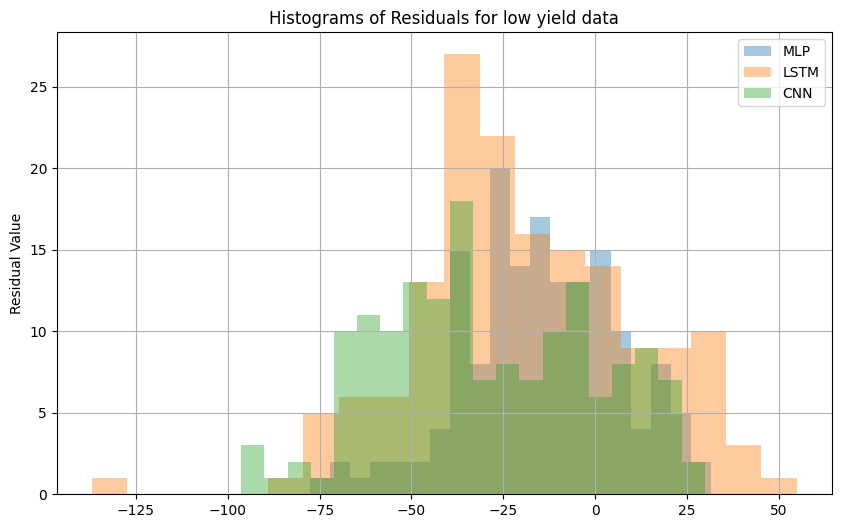

In [22]:
residuals_low_yield = [low_yield_labels - x for x in [mlp_low_predictions, lstm_low_predictions, cnn_low_predictions]]
residuals_for_plot = [residual.flatten() for residual in residuals_low_yield]

labels = ["MLP", "LSTM", "CNN"]

plt.figure(figsize=(10, 6))
for i, residual in enumerate(residuals_for_plot):
    plt.hist(residuals_for_plot[i], bins=20, alpha=0.4, label=labels[i])
    
plt.title('Histograms of Residuals for low yield data')
plt.ylabel('Residual Value')
plt.legend()
plt.grid(True)
plt.show()

#### LSTM investigation

In [23]:
lstm_model.model_name

In [24]:
lstm_model.name
model_path = rf"C:\Users\tskor\Documents\GitHub\inovation_project\2_gc-pipeline\models\saved\{lstm_model.model_name}.keras"


model = tf.keras.models.load_model(model_path)

c:\Users\tskor\Documents\GitHub\inovation_project\.ml-venv\Lib\site-packages\keras\src\saving\serialization_lib.py:734: UserWarning: `compile()` was not called as part of model loading because the model's `compile()` method is custom. All subclassed Models that have `compile()` overridden should also override `get_compile_config()` and `compile_from_config(config)`. Alternatively, you can call `compile()` manually after loading.
  instance.compile_from_config(compile_config)


In [25]:
def inspect_weight_statistics(model):
    for layer in model.layers:
        if layer.weights:
            print(f"\nLayer: {layer.name}")
            for weight in layer.weights:
                values = weight.numpy()
                print(f"\nWeight: {weight.name}")
                print(f"Shape: {values.shape}")
                print(f"Mean: {np.mean(values):.6f}")
                print(f"Std: {np.std(values):.6f}")
                print(f"Min: {np.min(values):.6f}")
                print(f"Max: {np.max(values):.6f}")
                # Check if weights follow specific distribution
                print("Distribution characteristics:")
                if np.abs(np.mean(values)) < 0.1 and 0.4 < np.std(values) < 0.8:
                    print("  Possibly Glorot/Xavier initialization")
                elif np.abs(np.mean(values)) < 0.1 and np.std(values) < 0.4:
                    print("  Possibly He/Kaiming initialization")

In [26]:
inspect_weight_statistics(lstm_model)


Layer: lstm

Weight: kernel
Shape: (541, 800)
Mean: 0.002526
Std: 0.081195
Min: -0.745202
Max: 0.761142
Distribution characteristics:
  Possibly He/Kaiming initialization

Weight: recurrent_kernel
Shape: (200, 800)
Mean: -0.000353
Std: 0.088571
Min: -0.447803
Max: 0.454695
Distribution characteristics:
  Possibly He/Kaiming initialization

Weight: bias
Shape: (800,)
Mean: 0.236772
Std: 0.425696
Min: -0.148329
Max: 1.131103
Distribution characteristics:

Layer: lstm_1

Weight: kernel
Shape: (200, 800)
Mean: 0.002249
Std: 0.088880
Min: -0.498313
Max: 0.473913
Distribution characteristics:
  Possibly He/Kaiming initialization

Weight: recurrent_kernel
Shape: (200, 800)
Mean: 0.002534
Std: 0.090115
Min: -0.480253
Max: 0.493186
Distribution characteristics:
  Possibly He/Kaiming initialization

Weight: bias
Shape: (800,)
Mean: 0.187802
Std: 0.415265
Min: -0.143360
Max: 1.053903
Distribution characteristics:

Layer: lstm_2

Weight: kernel
Shape: (200, 800)
Mean: 0.002409
Std: 0.072743
Min: 

In [27]:
lstm_weights_path = r"C:\Users\tskor\Documents\GitHub\inovation_project\2_gc-pipeline\models\saved\good_lstm_weights"
save_weight_statistics(lstm_model, lstm_weights_path)

Weight statistics saved to: C:\Users\tskor\Documents\GitHub\inovation_project\2_gc-pipeline\models\saved\good_lstm_weights/weight_stats_lstm_with_attention_20241104-003553.json


{'model_name': 'lstm_with_attention',
 'timestamp': '20241104-003553',
 'layers': [{'layer_name': 'lstm',
   'layer_type': 'LSTM',
   'weights': [{'weight_name': 'kernel',
     'shape': [541, 800],
     'statistics': {'mean': 0.0025255035143345594,
      'std': 0.08119505643844604,
      'min': -0.7452023029327393,
      'max': 0.7611423134803772,
      'median': 0.002000933513045311,
      'quartiles': [-0.0513704102486372, 0.05574781261384487]},
     'likely_initialization': 'possibly_he'},
    {'weight_name': 'recurrent_kernel',
     'shape': [200, 800],
     'statistics': {'mean': -0.00035253787063993514,
      'std': 0.08857088536024094,
      'min': -0.4478026330471039,
      'max': 0.4546947777271271,
      'median': -0.0005358813796192408,
      'quartiles': [-0.05788655299693346, 0.05730887595564127]},
     'likely_initialization': 'possibly_he'},
    {'weight_name': 'bias',
     'shape': [800],
     'statistics': {'mean': 0.23677240312099457,
      'std': 0.4256961941719055,
